In [1]:
# =============================================================================
# Cell 1: Import Libraries
# =============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge, Lasso
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.model_selection import cross_val_score
import warnings
warnings.filterwarnings('ignore')

print("Libraries imported successfully!")

Libraries imported successfully!


In [2]:
# =============================================================================
# Cell 2: Load Data and Previous Results
# =============================================================================

# Load feature engineering results
with open('../src/models/train_test_splits.pkl', 'rb') as f:
    splits = pickle.load(f)

# Load previous model results
with open('../src/models/final_model_results.pkl', 'rb') as f:
    previous_results = pickle.load(f)

print("Data loaded successfully!")
print(f"Previous best model: {previous_results['model_name']}")
print(f"Previous best MAE: {previous_results['test_mae']:.3f}")

# Use combined features
X_train = splits['combined']['X_train']
X_test = splits['combined']['X_test']
y_train = splits['combined']['y_train']
y_test = splits['combined']['y_test']

print(f"Training data shape: {X_train.shape}")
print(f"Test data shape: {X_test.shape}")


Data loaded successfully!
Previous best model: Optimized Ridge Regression
Previous best MAE: 0.757
Training data shape: (10978, 5010)
Test data shape: (2745, 5010)


In [3]:
# =============================================================================
# Cell 3: Define Evaluation Function
# =============================================================================

def evaluate_hyperparameter_search(model, param_grid, X_train, y_train, 
                                 search_type='grid', n_iter=50, cv=5):
    """
    Perform hyperparameter search and return best model
    """
    print(f"\nStarting {search_type} search...")
    print(f"Parameter grid: {param_grid}")
    
    # Create scorer
    mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)
    
    # Choose search method
    if search_type == 'grid':
        search = GridSearchCV(
            model, param_grid, cv=cv, scoring=mae_scorer,
            n_jobs=-1, verbose=1
        )
    else:  # random search
        search = RandomizedSearchCV(
            model, param_grid, n_iter=n_iter, cv=cv, scoring=mae_scorer,
            n_jobs=-1, verbose=1, random_state=42
        )
    
    # Fit search
    search.fit(X_train, y_train)
    
    # Results
    results = {
        'best_params': search.best_params_,
        'best_cv_score': -search.best_score_,
        'best_model': search.best_estimator_,
        'cv_results': search.cv_results_
    }
    
    print(f"Best parameters: {results['best_params']}")
    print(f"Best CV MAE: {results['best_cv_score']:.3f}")
    
    return results

In [4]:
# =============================================================================
# Cell 4: Random Forest Hyperparameter Optimization
# =============================================================================

print("=" * 50)
print("RANDOM FOREST HYPERPARAMETER OPTIMIZATION")
print("=" * 50)

# Define parameter grid for Random Forest
rf_param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [10, 15, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2']
}

# First do random search to narrow down
rf_random_results = evaluate_hyperparameter_search(
    RandomForestRegressor(random_state=42),
    rf_param_grid, 
    X_train, 
    y_train,
    search_type='random', 
    n_iter=20,
    cv=3  
)

# Extract best params
best_n_est = rf_random_results['best_params']['n_estimators']
best_depth = rf_random_results['best_params']['max_depth']


rf_grid_refined = {
    'n_estimators': [best_n_est, best_n_est + 50],
    'max_depth': [best_depth, best_depth + 2] if best_depth else [10, 15],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

rf_grid_results = evaluate_hyperparameter_search(
    RandomForestRegressor(random_state=42),
    rf_grid_refined, 
    X_train, 
    y_train,
    search_type='grid',
    cv=3
)

print(f"\nRandom Forest Optimization Results:")
print(f"Random search best MAE: {rf_random_results['best_cv_score']:.3f}")
print(f"Grid search best MAE: {rf_grid_results['best_cv_score']:.3f}")

RANDOM FOREST HYPERPARAMETER OPTIMIZATION

Starting random search...
Parameter grid: {'n_estimators': [50, 100, 150], 'max_depth': [10, 15, None], 'min_samples_split': [2, 5], 'min_samples_leaf': [1, 2], 'max_features': ['sqrt', 'log2']}
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best parameters: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': None}
Best CV MAE: 0.854

Starting grid search...
Parameter grid: {'n_estimators': [100, 150], 'max_depth': [10, 15], 'min_samples_split': [2, 5], 'min_samples_leaf': [1, 2]}
Fitting 3 folds for each of 16 candidates, totalling 48 fits
Best parameters: {'max_depth': 15, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 150}
Best CV MAE: 0.832

Random Forest Optimization Results:
Random search best MAE: 0.854
Grid search best MAE: 0.832


In [5]:
# =============================================================================
# Cell 5: Ridge Regression Hyperparameter Optimization
# =============================================================================

print("\n" + "=" * 50)
print("RIDGE REGRESSION HYPERPARAMETER OPTIMIZATION")
print("=" * 50)

# Ridge parameter grid
ridge_param_grid = {
    'alpha': [0.01, 0.1, 1.0, 10.0],  
    'solver': ['auto', 'lsqr', 'saga'] 
}

ridge_results = evaluate_hyperparameter_search(
    Ridge(), ridge_param_grid, X_train, y_train,
    search_type='grid'
)

print(f"\nRidge Regression Optimization Results:")
print(f"Best MAE: {ridge_results['best_cv_score']:.3f}")


RIDGE REGRESSION HYPERPARAMETER OPTIMIZATION

Starting grid search...
Parameter grid: {'alpha': [0.01, 0.1, 1.0, 10.0], 'solver': ['auto', 'lsqr', 'saga']}
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best parameters: {'alpha': 1.0, 'solver': 'lsqr'}
Best CV MAE: 0.777

Ridge Regression Optimization Results:
Best MAE: 0.777


In [ ]:
# =============================================================================
# Cell 6: SVR Hyperparameter Optimization
# =============================================================================

print("\n" + "="*50)
print("SVR HYPERPARAMETER OPTIMIZATION")
print("="*50)

# SVR parameter grid
svr_param_grid = {
    'C': [0.1, 1.0, 10.0],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto', 0.01],
    'epsilon': [0.1, 0.2]
}

# Use random search for SVR due to large parameter space
svr_results = evaluate_hyperparameter_search(
    SVR(), svr_param_grid, X_train, y_train,
    search_type='random', n_iter=20, cv=2
)

print(f"\nSVR Optimization Results:")
print(f"Best MAE: {svr_results['best_cv_score']:.3f}")


SVR HYPERPARAMETER OPTIMIZATION

Starting random search...
Parameter grid: {'C': [0.1, 1.0, 10.0], 'kernel': ['linear', 'rbf'], 'gamma': ['scale', 'auto', 0.01], 'epsilon': [0.1, 0.2]}
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best parameters: {'kernel': 'rbf', 'gamma': 'scale', 'epsilon': 0.2, 'C': 10.0}
Best CV MAE: 0.741

SVR Optimization Results:
Best MAE: 0.741


In [7]:
# =============================================================================
# Cell 7: KNN Hyperparameter Optimization
# =============================================================================

print("\n" + "=" * 50)
print("KNN HYPERPARAMETER OPTIMIZATION")
print("=" * 50)


# KNN parameter grid
knn_param_grid = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto'],     
    'p': [1, 2] # Manhattan and Euclidean
}

knn_results = evaluate_hyperparameter_search(
    KNeighborsRegressor(), 
    knn_param_grid, 
    X_train, 
    y_train,
    search_type='grid'
)

print(f"\nKNN Optimization Results:")
print(f"Best MAE: {knn_results['best_cv_score']:.3f}")


KNN HYPERPARAMETER OPTIMIZATION

Starting grid search...
Parameter grid: {'n_neighbors': [3, 5, 7, 9], 'weights': ['uniform', 'distance'], 'algorithm': ['auto'], 'p': [1, 2]}
Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best parameters: {'algorithm': 'auto', 'n_neighbors': 7, 'p': 1, 'weights': 'distance'}
Best CV MAE: 0.954

KNN Optimization Results:
Best MAE: 0.954


In [8]:
# =============================================================================
# Cell 8: Decision Tree Hyperparameter Optimization
# =============================================================================

print("\n" + "=" * 50)
print("DECISION TREE HYPERPARAMETER OPTIMIZATION")
print("=" * 50)

# Decision Tree parameter grid
dt_param_grid = {
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['squared_error'],
    'splitter': ['best']
}

dt_results = evaluate_hyperparameter_search(
    DecisionTreeRegressor(random_state=42),
    dt_param_grid, X_train, y_train,
    search_type='random', n_iter=20
)

print(f"\nDecision Tree Optimization Results:")
print(f"Best MAE: {dt_results['best_cv_score']:.3f}")


DECISION TREE HYPERPARAMETER OPTIMIZATION

Starting random search...
Parameter grid: {'max_depth': [5, 10, 15, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'criterion': ['squared_error'], 'splitter': ['best']}
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best parameters: {'splitter': 'best', 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_depth': None, 'criterion': 'squared_error'}
Best CV MAE: 0.848

Decision Tree Optimization Results:
Best MAE: 0.848


In [10]:
# =============================================================================
# Cell 9: Compare All Optimized Models
# =============================================================================

print("\n" + "="*70)
print("OPTIMIZED MODEL COMPARISON")
print("="*70)

# Compile all results
all_optimized_results = {
    'Random Forest': rf_grid_results,
    'Ridge Regression': ridge_results,
    'SVR': svr_results,
    'KNN': knn_results,
    'Decision Tree': dt_results
}

# Create comparison DataFrame
comparison_data = []
for model_name, results in all_optimized_results.items():
    comparison_data.append({
        'Model': model_name,
        'Best CV MAE': results['best_cv_score'],
        'Best Parameters': str(results['best_params'])
    })

comparison_df = pd.DataFrame(comparison_data)
comparison_df = comparison_df.sort_values('Best CV MAE')

print("Optimized Model Comparison:")
print(comparison_df.to_string(index=False))


OPTIMIZED MODEL COMPARISON
Optimized Model Comparison:
           Model  Best CV MAE                                                                                                       Best Parameters
             SVR     0.741101                                                        {'kernel': 'rbf', 'gamma': 'scale', 'epsilon': 0.2, 'C': 10.0}
Ridge Regression     0.777247                                                                                      {'alpha': 1.0, 'solver': 'lsqr'}
   Random Forest     0.831637                                 {'max_depth': 15, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 150}
   Decision Tree     0.848411 {'splitter': 'best', 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_depth': None, 'criterion': 'squared_error'}
             KNN     0.954196                                                {'algorithm': 'auto', 'n_neighbors': 7, 'p': 1, 'weights': 'distance'}



VISUALIZATION OF OPTIMIZATION RESULTS


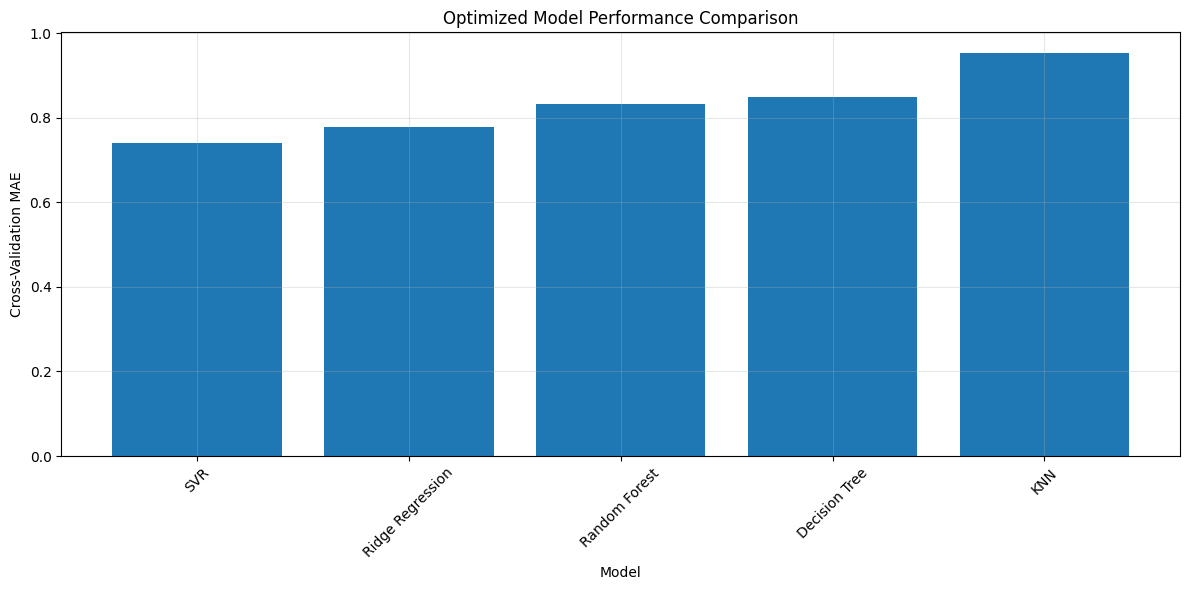


Parameter analysis only available for Random Forest.
Current best model is SVR


In [11]:
# =============================================================================
# Cell 10: Visualize Hyperparameter Optimization Results
# =============================================================================

print("\n" + "="*50)
print("VISUALIZATION OF OPTIMIZATION RESULTS")
print("="*50)

# Bar plot of model performance
plt.figure(figsize=(12, 6))
plt.bar(comparison_df['Model'], comparison_df['Best CV MAE'])
plt.title('Optimized Model Performance Comparison')
plt.xlabel('Model')
plt.ylabel('Cross-Validation MAE')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Random Forest parameter importance (if it's the best model)
best_model_name = comparison_df.iloc[0]['Model']
if best_model_name == 'Random Forest':
    print("\nRandom Forest Parameter Analysis:")
    
    # Extract CV results for Random Forest
    cv_results = rf_grid_results['cv_results']
    
    # Create parameter analysis plots
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # n_estimators effect
    param_data = pd.DataFrame(cv_results)
    param_data['mean_test_score'] = -param_data['mean_test_score']
    
    # Plot parameter effects
    for i, param in enumerate(['param_n_estimators', 'param_max_depth', 
                              'param_min_samples_split', 'param_min_samples_leaf']):
        if param in param_data.columns:
            ax = axes[i//2, i%2]
            grouped = param_data.groupby(param)['mean_test_score'].mean()
            grouped.plot(kind='bar', ax=ax)
            ax.set_title(f'Effect of {param.replace("param_", "")}')
            ax.set_ylabel('CV MAE')
            ax.tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()
else:
    print(f"\nParameter analysis only available for Random Forest.")
    print(f"Current best model is {best_model_name}")

In [12]:
# =============================================================================
# Cell 11: Final Model Selection and Evaluation
# =============================================================================

print("\n" + "="*50)
print("FINAL MODEL SELECTION AND EVALUATION")
print("="*50)

# Select best model
best_model = all_optimized_results[best_model_name]['best_model']
best_params = all_optimized_results[best_model_name]['best_params']
best_cv_mae = all_optimized_results[best_model_name]['best_cv_score']

print(f"Selected best model: {best_model_name}")
print(f"Best parameters: {best_params}")
print(f"Best CV MAE: {best_cv_mae:.3f}")

# Train final model and evaluate on test set
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

# Calculate final metrics
final_mae = mean_absolute_error(y_test, y_pred)
final_rmse = np.sqrt(np.mean((y_test - y_pred)**2))
final_r2 = best_model.score(X_test, y_test)

print(f"\nFinal Test Set Performance:")
print(f"MAE: {final_mae:.3f}")
print(f"RMSE: {final_rmse:.3f}")
print(f"R²: {final_r2:.3f}")

# Compare with previous results
improvement = ((previous_results['test_mae'] - final_mae) / previous_results['test_mae']) * 100
print(f"\nImprovement over previous best:")
print(f"Previous MAE: {previous_results['test_mae']:.3f}")
print(f"New MAE: {final_mae:.3f}")
print(f"Improvement: {improvement:.1f}%")



FINAL MODEL SELECTION AND EVALUATION
Selected best model: SVR
Best parameters: {'kernel': 'rbf', 'gamma': 'scale', 'epsilon': 0.2, 'C': 10.0}
Best CV MAE: 0.741

Final Test Set Performance:
MAE: 0.721
RMSE: 0.975
R²: 0.700

Improvement over previous best:
Previous MAE: 0.757
New MAE: 0.721
Improvement: 4.8%



LEARNING CURVES ANALYSIS


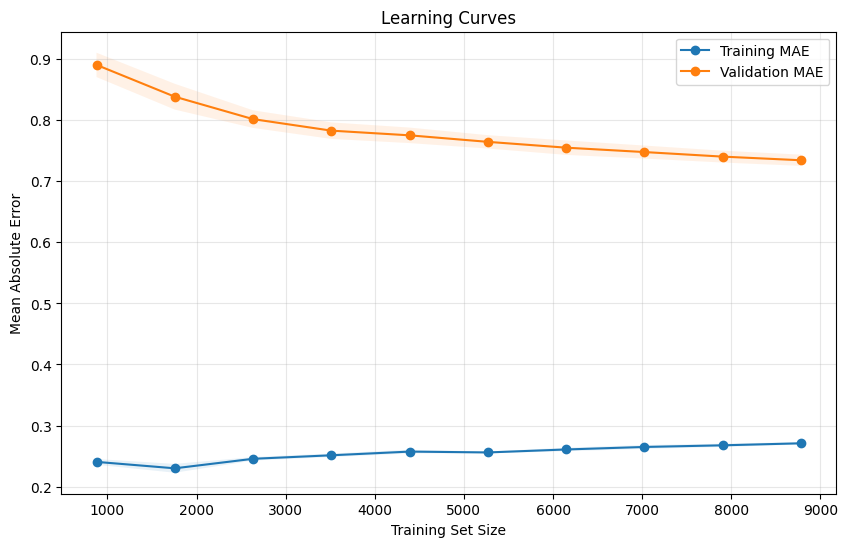

Learning curve analysis shows:
Final training MAE: 0.271
Final validation MAE: 0.735
Gap (overfitting): -0.464


In [13]:
# =============================================================================
# Cell 12: Learning Curves Analysis
# =============================================================================

print("\n" + "="*50)
print("LEARNING CURVES ANALYSIS")
print("="*50)

from sklearn.model_selection import learning_curve

# Generate learning curves for best model
train_sizes, train_scores, val_scores = learning_curve(
    best_model, X_train, y_train, cv=5,
    train_sizes=np.linspace(0.1, 1.0, 10),
    scoring='neg_mean_absolute_error',
    n_jobs=-1
)

# Convert to positive MAE
train_scores = -train_scores
val_scores = -val_scores

# Calculate means and standard deviations
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

# Plot learning curves
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, 'o-', label='Training MAE')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1)
plt.plot(train_sizes, val_mean, 'o-', label='Validation MAE')
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.1)
plt.xlabel('Training Set Size')
plt.ylabel('Mean Absolute Error')
plt.title('Learning Curves')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print("Learning curve analysis shows:")
print(f"Final training MAE: {train_mean[-1]:.3f}")
print(f"Final validation MAE: {val_mean[-1]:.3f}")
print(f"Gap (overfitting): {train_mean[-1] - val_mean[-1]:.3f}")

In [14]:
# =============================================================================
# Cell 13: Feature Importance Analysis (if applicable)
# =============================================================================

if hasattr(best_model, 'feature_importances_'):
    print("\n" + "="*50)
    print("FEATURE IMPORTANCE ANALYSIS")
    print("="*50)
    
    # Load feature names
    with open('src/models/feature_info.pkl', 'rb') as f:
        feature_info = pickle.load(f)
    
    feature_names = (feature_info['tfidf_features'] + 
                    feature_info['numerical_features'])
    
    # Get feature importances
    importances = best_model.feature_importances_
    
    # Create feature importance DataFrame
    feature_importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': importances
    }).sort_values('importance', ascending=False)
    
    print("Top 15 most important features:")
    print(feature_importance_df.head(15))
    
    # Plot feature importance
    plt.figure(figsize=(12, 8))
    top_features = feature_importance_df.head(20)
    plt.barh(range(len(top_features)), top_features['importance'])
    plt.yticks(range(len(top_features)), top_features['feature'])
    plt.xlabel('Importance')
    plt.title('Top 20 Feature Importances')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

In [15]:
# =============================================================================
# Cell 14: Model Stability Analysis
# =============================================================================

print("\n" + "="*50)
print("MODEL STABILITY ANALYSIS")
print("="*50)

# Test model stability with different random seeds
stability_results = []
for seed in range(5):
    if best_model_name == 'Random Forest':
        model = RandomForestRegressor(**best_params, random_state=seed)
    elif best_model_name == 'Decision Tree':
        model = DecisionTreeRegressor(**best_params, random_state=seed)
    else:
        model = type(best_model)(**best_params)
    
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, pred)
    stability_results.append(mae)

stability_mean = np.mean(stability_results)
stability_std = np.std(stability_results)

print(f"Model stability analysis (5 different seeds):")
print(f"Mean MAE: {stability_mean:.3f}")
print(f"Std MAE: {stability_std:.3f}")
print(f"Coefficient of variation: {(stability_std/stability_mean)*100:.1f}%")

if stability_std < 0.01:
    print("✓ Model is very stable")
elif stability_std < 0.05:
    print("✓ Model is reasonably stable")
else:
    print("⚠ Model shows some instability")



MODEL STABILITY ANALYSIS
Model stability analysis (5 different seeds):
Mean MAE: 0.721
Std MAE: 0.000
Coefficient of variation: 0.0%
✓ Model is very stable


In [18]:
# =============================================================================
# Cell 15: Save Optimized Model
# =============================================================================

print("\n" + "="*50)
print("SAVING OPTIMIZED MODEL")
print("="*50)

# Save the optimized model
#import os
#os.makedirs('../src/models', exist_ok=True)

with open('../src/models/optimized_model.pkl', 'wb') as f:
    pickle.dump(best_model, f)

# Save optimization results
optimization_results = {
    'best_model_name': best_model_name,
    'best_params': best_params,
    'best_cv_mae': best_cv_mae,
    'test_mae': final_mae,
    'test_rmse': final_rmse,
    'test_r2': final_r2,
    'improvement_over_previous': improvement,
    'stability_mean': stability_mean,
    'stability_std': stability_std,
    'all_model_results': {name: results['best_cv_score'] 
                         for name, results in all_optimized_results.items()}
}

with open('../src/models/optimization_results.pkl', 'wb') as f:
    pickle.dump(optimization_results, f)

print("Optimized model saved successfully!")
print(f"Best model: {best_model_name}")
print(f"Test MAE: {final_mae:.3f}")
print(f"Improvement: {improvement:.1f}%")


SAVING OPTIMIZED MODEL
Optimized model saved successfully!
Best model: SVR
Test MAE: 0.721
Improvement: 4.8%


In [ ]:
# =============================================================================
# Cell 16: Hyperparameter Optimization Summary
# =============================================================================

print("\n" + "="*70)
print("HYPERPARAMETER OPTIMIZATION SUMMARY")
print("="*70)

print("\n1. Models Optimized:")
for model_name, results in all_optimized_results.items():
    print(f"   - {model_name}: {results['best_cv_score']:.3f} MAE")

print(f"\n2. Best Model: {best_model_name}")
print(f"   - Best parameters: {best_params}")
print(f"   - CV MAE: {best_cv_mae:.3f}")
print(f"   - Test MAE: {final_mae:.3f}")

print(f"\n3. Improvement Analysis:")
print(f"   - Previous best: {previous_results['test_mae']:.3f} MAE")
print(f"   - New best: {final_mae:.3f} MAE")
print(f"   - Improvement: {improvement:.1f}%")

print(f"\n4. Model Stability:")
print(f"   - Mean MAE: {stability_mean:.3f}")
print(f"   - Std MAE: {stability_std:.3f}")

print("\n5. Key Insights:")
if best_model_name == 'Random Forest':
    print("   - Random Forest benefits from hyperparameter tuning")
    print("   - n_estimators and max_depth are key parameters")
    print("   - Balanced complexity prevents overfitting")
elif best_model_name == 'Ridge Regression':
    print("   - Ridge alpha parameter is crucial")
    print("   - Optimal regularization strength found")
    print("   - Solver choice impacts performance")

print("\nHyperparameter optimization completed successfully!")


HYPERPARAMETER OPTIMIZATION SUMMARY

1. Models Optimized:
   - Random Forest: 0.832 MAE
   - Ridge Regression: 0.777 MAE
   - SVR: 0.741 MAE
   - KNN: 0.954 MAE
   - Decision Tree: 0.848 MAE

2. Best Model: SVR
   - Best parameters: {'kernel': 'rbf', 'gamma': 'scale', 'epsilon': 0.2, 'C': 10.0}
   - CV MAE: 0.741
   - Test MAE: 0.721

3. Improvement Analysis:
   - Previous best: 0.757 MAE
   - New best: 0.721 MAE
   - Improvement: 4.8%

4. Model Stability:
   - Mean MAE: 0.721
   - Std MAE: 0.000

5. Key Insights:

Hyperparameter optimization completed successfully!
